In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

In [220]:
keys = ['R_break', 'lnxsigma', 'logrsigma', 'p_break', 'power_long', 'power_short']#, 'xsigma', 'lnp_break']
labels = ["$R_\mathrm{break}$ (ppm)", "$\ln \sigma_{\ln P}$ (days)", "$\ln \sigma_{\ln R}$ (ppm)", "$P_\mathrm{break}$ (days)", 
          r"$\beta_\mathrm{unsat}$", r"$\beta_\mathrm{sat}$"] 
logs = [True, False, False, True*0, False, False]

In [221]:
def summary_plots(resdir, dt):
    sall = None
    figdir = resdir[:-1]+"_plots/"
    if not os.path.exists(figdir):
        os.system("mkdir %s"%figdir)
    files = glob.glob(resdir+"*.pkl")
    files.sort()
    d = pd.DataFrame({})
    for i,file in enumerate(files):
        _f = file.split("/")[1]
        tl, tu = float(_f[4:8]), float(_f[9:13])
        if tu - tl > 1000:
            sall = dill.load(open(file, 'rb')).get_samples()
            continue
        s = dill.load(open(file, 'rb')).get_samples()
        dic = {"tl": tl, "tu": tu, "t": 0.5*(tl+tu)}
        for k in keys:
            dic[k+"_mean"] = np.mean(s[k])
            dic[k+"_median"] = np.median(s[k])
            dic[k+"5"], dic[k+"95"] = np.percentile(s[k], [5, 95])
            dic[k+"_upp"] = dic[k+"95"] - dic[k+"_mean"]
            dic[k+"_low"] = -dic[k+"5"] + dic[k+"_mean"]
        d = d.append([dic])

    for i in range(len(keys)):
        key = keys[i]
        plt.figure(figsize=(12*0.9,7*0.9))
        plt.xlim(4000+100, 6500-200)
        plt.xlabel("LAMOST $T_\mathrm{eff}$ (K)")
        plt.gca().yaxis.set_label_coords(-0.09, 0.5)
        if logs[i]:
            #plt.xscale("log")
            plt.yscale("log")
        if key=='p_break' and ('ro' in resdir):
            _label = "$\mathrm{Ro}_\mathrm{break}$"
            plt.ylabel(_label)
            plt.yscale("linear")
        elif key=='lnxsigma' and 'ro' in resdir:
            _label = "$\ln \sigma_{\ln \mathrm{Ro}}$"
            plt.ylabel(_label)
        else:
            _label = labels[i]
            plt.ylabel(labels[i])
        idx = (4200 <= d.t) & (d.t <= 6200)
        plt.errorbar(d.t[idx], d[key+"_mean"][idx], yerr=[d[key+"_low"][idx], d[key+"_upp"][idx]], 
                     fmt='o', lw=1, xerr=0.5*dt, color='gray')
        if sall is not None:
            allm = np.mean(sall[key])
            all5, all95 = np.percentile(sall[key], [5,95])
            if key=='R_break':
                __label = _label+r"$=(1.08\pm0.04)\times10^4$"
            else:
                __label = _label+"$=%.2f^{+%.2f}_{-%.2f}$\n(mean \& 90%s from the entire sample)"%(allm, all95-allm, allm-all5, "\%")
            plt.axhline(y=allm, color='C1', ls='dashed', lw=1, 
                        label=__label)
            plt.fill_between(np.linspace(4100, 6300, 100), all5, all95, color='C1', alpha=0.2)
            plt.legend(loc='best')
        if 'ro' not in resdir:
            rotag = ''
        else:
            rotag = '_ro'
        plt.savefig(figdir+"%s_teff%s.png"%(key,rotag), dpi=200, bbox_inches="tight")

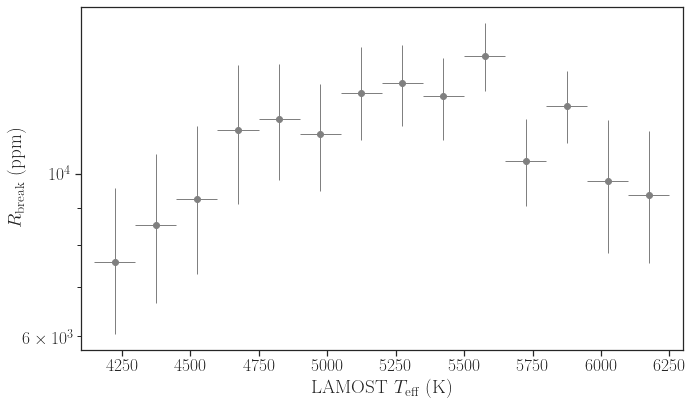

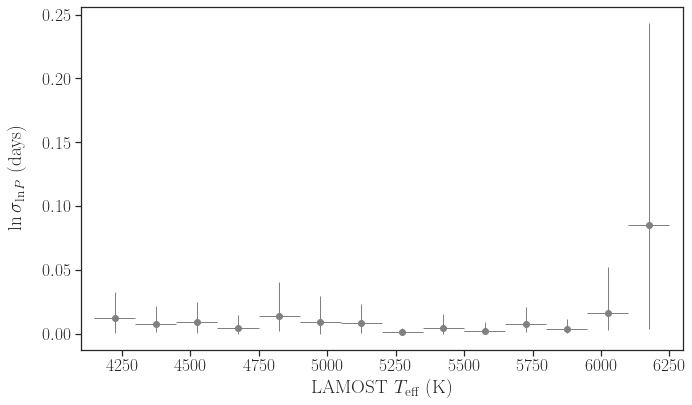

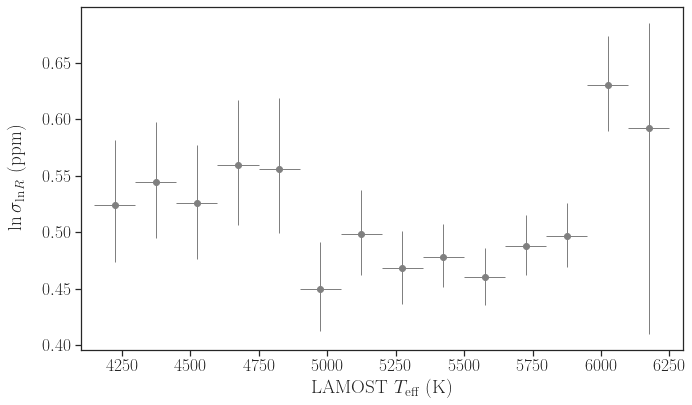

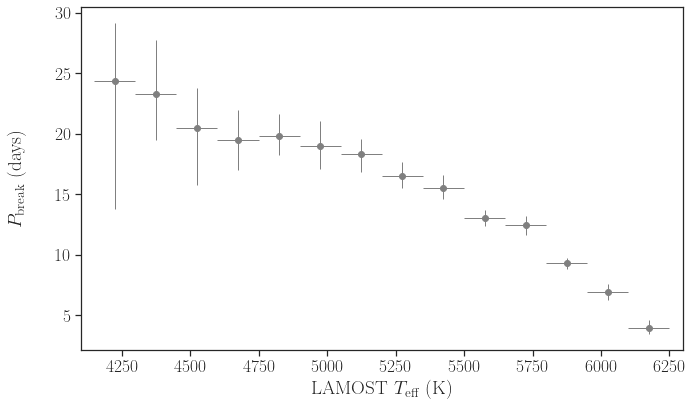

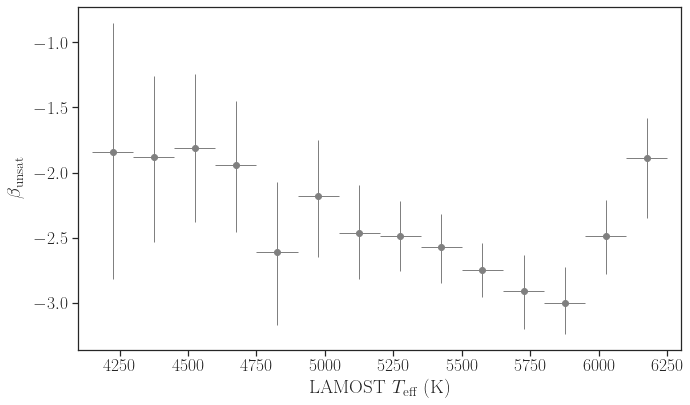

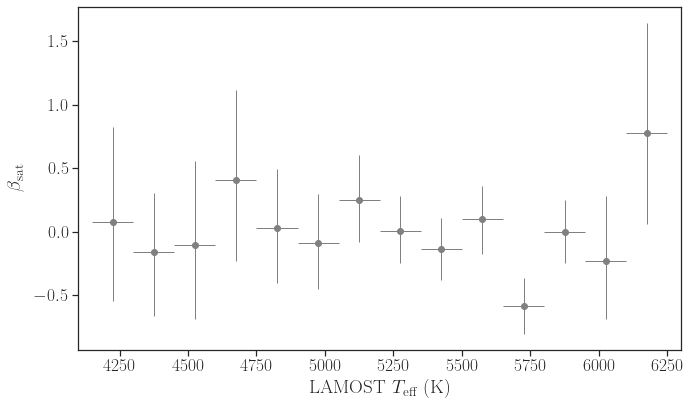

In [222]:
dt = 150
resdir = 'plfit_results_t%d_pct/'%dt
summary_plots(resdir, dt)

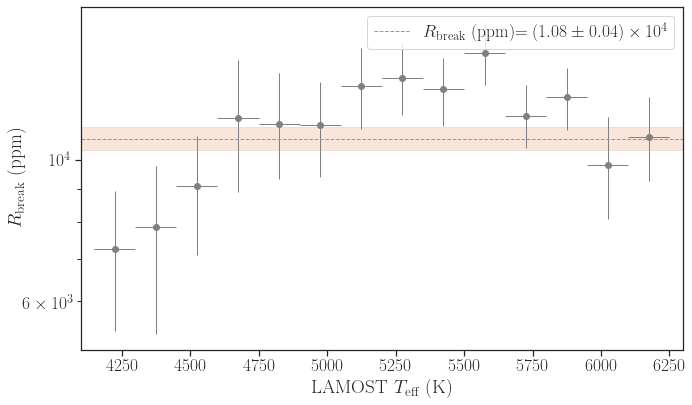

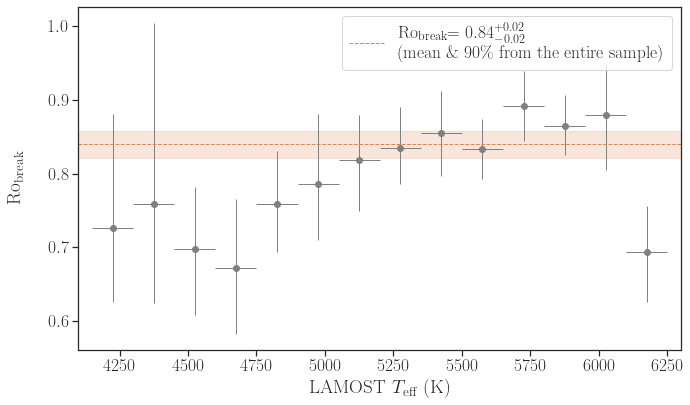

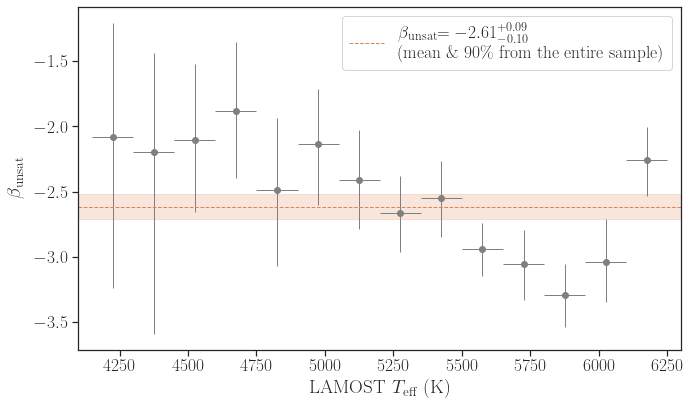

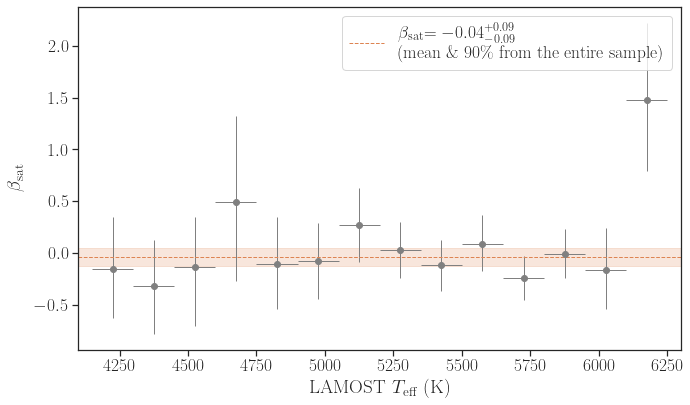

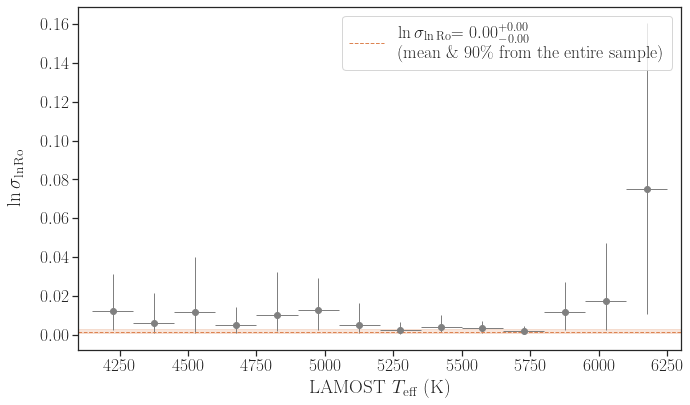

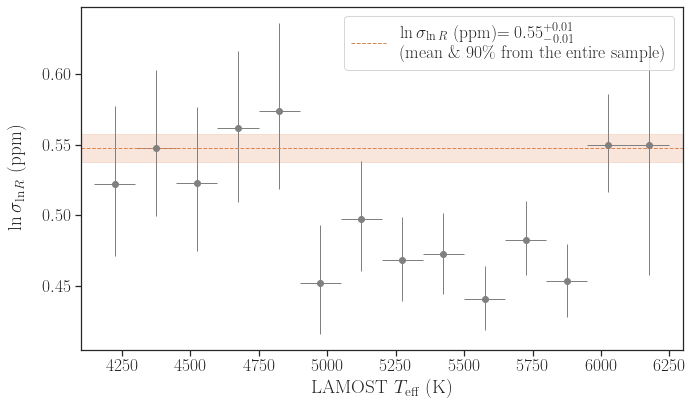

In [215]:
dt = 150
resdir = 'plfitro_results_t%d_pct/'%dt
summary_plots(resdir, dt)

In [189]:
postall = "plfitro_results_t150_pct/teff4000-6250_mcmc.pkl"
#postall = "plfitro_results_t200_pct/teff4000-6200_mcmc.pkl"

In [190]:
s = dill.load(open(postall, 'rb')).get_samples()

In [191]:
keys = ['R_break', 'p_break', 'power_long', 'power_short', 'lnxsigma', 'logrsigma']#, 'xsigma', 'lnp_break']
labels = ["$R_\mathrm{break}$ (ppm)", "$\mathrm{Ro}_\mathrm{break}$", 
          r"$\beta_\mathrm{unsat}$", r"$\beta_\mathrm{sat}$",
          "$\ln \sigma_{\ln\mathrm{Ro}}$", "$\ln \sigma_{\ln R}$ (ppm)"] 

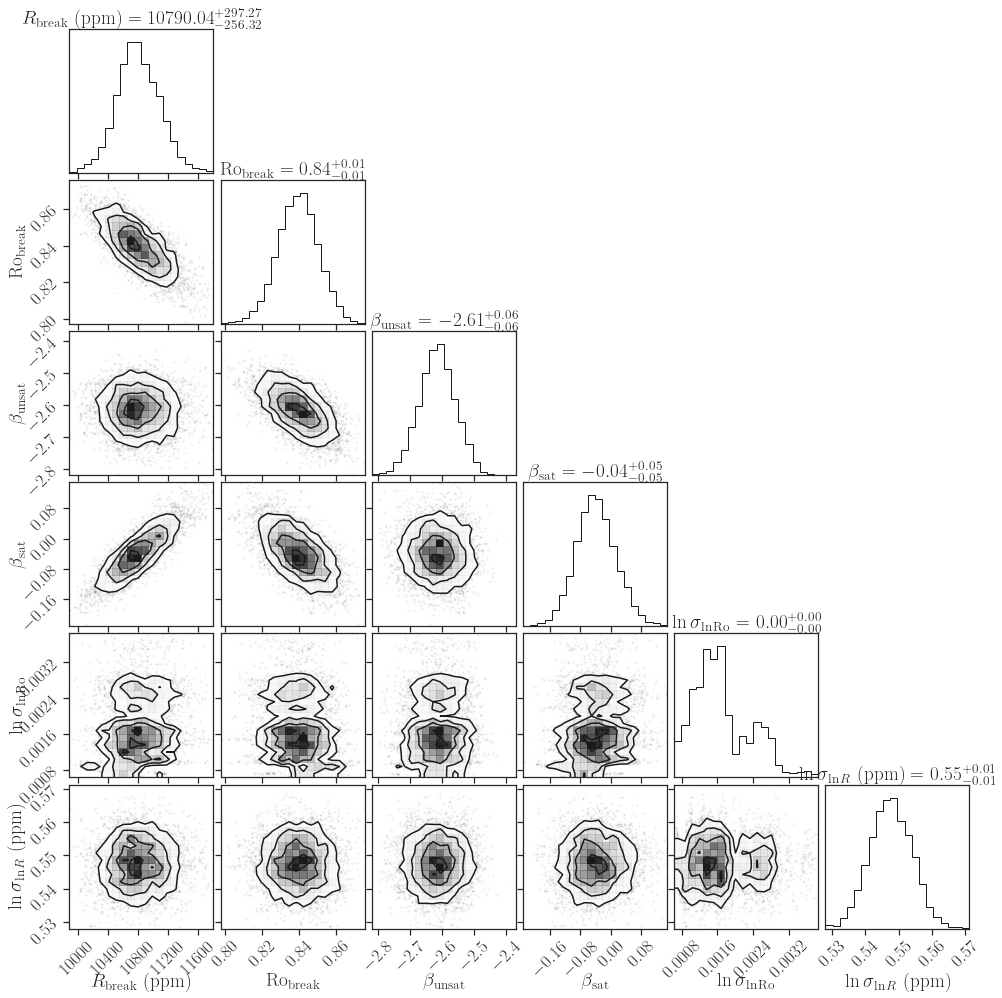

In [192]:
hyper = pd.DataFrame(data=dict(zip(keys, [s[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
plt.savefig(postall.split("/")[0]+"_plots/all_corner.png", dpi=200, bbox_inches="tight")

## Hierarchical modeling assuming that the true distribution is Gaussian

In [18]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [85]:
keys = ['power_long', 'power_short', "p_break", "lnRbreak"]
mulims = [[-5,-1], [-3,3], [0,2], [3,5],]
slims = [[0,3], [0,3], [0,1], [0,2]]

In [86]:
def model(samples, mulim, slim):
    mu = numpyro.sample("mu", dist.Uniform(mulim[0], mulim[1]))
    sigma = numpyro.sample("sigma", dist.Uniform(slim[0], slim[1]))
    norm = dist.Normal(loc=mu, scale=sigma)
    lnprob = numpyro.deterministic("lnprob", jnp.log(jnp.prod(jnp.mean(jnp.exp(norm.log_prob(samples)), axis=1))))
    numpyro.factor("lnlike", lnprob)

In [87]:
resdir = 'plfitro_results_t%d_pct/'%dt
figdir = resdir[:-1]+"_plots/"

In [89]:
resdir = 'plfit_results_t%d_pct/'%dt
figdir = resdir[:-1]+"_plots/"

sample: 100%|███████████| 2000/2000 [00:02<00:00, 779.11it/s, 7 steps of size 5.36e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -2.09      0.25     -2.08     -2.49     -1.70    493.25      1.00
     sigma      0.96      0.21      0.93      0.63      1.28    539.74      1.00

Number of divergences: 0


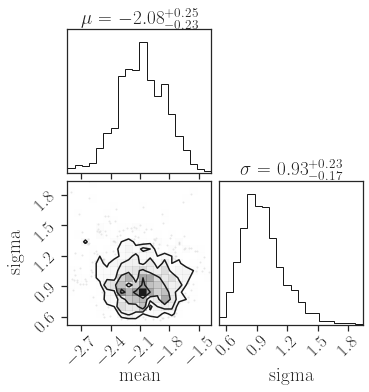

In [92]:
for i in range(len(keys)):
    key, mulim, slim = keys[i], mulims[i], slims[i]
    
    if key=='p_break' and ('ro' not in resdir):
        continue
    
    samples = []
    files = glob.glob(resdir+"*.pkl")
    files.sort()
    for i,file in enumerate(files):
        _f = file.split("/")[1]
        tl, tu = float(_f[4:8]), float(_f[9:13])
        s = dill.load(open(file, 'rb')).get_samples()
        s['lnRbreak'] = jnp.log10(s['R_break'])
        samples.append(s[key])
    samples = np.array(samples)
    
    kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
    nw, ns = 1000, 1000
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, samples, mulim, slim)
    mcmc.print_summary()
    
    _s = mcmc.get_samples()
    fig = corner.corner(np.array([_s['mu'], _s['sigma']]).T, labels=['mean', 'sigma'], 
                        titles=['$\mu$', '$\sigma$'], show_titles=True)
    plt.savefig(figdir+"musigma_%s.png"%key, dpi=200, bbox_inches='tight')